# Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import re
import sys

In [2]:
gut_16s_df = pd.read_table("./data/gut_16s_abundance.txt", index_col=0)
metabolome_df = pd.read_table("./data/metabolome_abundance.txt", index_col=0)
metabolome_df = metabolome_df.drop(columns=['SubjectID', 'CollectionDate', 'CL1', 'CL2', 'CL3', 'CL4'])
subjects = pd.read_csv("./data/subjects.csv", na_values="NA")

In [3]:
from sklearn.preprocessing import StandardScaler
gut_16s_df_array = StandardScaler().fit_transform(gut_16s_df)
gut_16s_df = pd.DataFrame(gut_16s_df_array, index=gut_16s_df.index, columns=gut_16s_df.columns)

metabolome_df_array = StandardScaler().fit_transform(metabolome_df)
metabolome_df = pd.DataFrame(metabolome_df_array, index=metabolome_df.index, columns=metabolome_df.columns)

In [4]:
# Get indexes for shared patient ids
indexes = list(set(gut_16s_df.index.values) & set(metabolome_df.index.values))
indexes.sort()
print("# of patients: {}".format(len(indexes)))

# of patients: 720


In [5]:
def pca_scatter_plot_original_data(covariate):
    # Load training, validation and testing indexes
    indexes_noukn = np.genfromtxt('./data/index/{}/indexes_noukn.txt'.format(covariate), dtype='str')
    indexes_train = np.genfromtxt('./data/index/{}/indexes_train.txt'.format(covariate), dtype='str')
    indexes_val = np.genfromtxt('./data/index/{}/indexes_val.txt'.format(covariate), dtype='str')
    indexes_test = np.genfromtxt('./data/index/{}/indexes_test.txt'.format(covariate), dtype='str')

    g_train = gut_16s_df.loc[indexes_train, :]
    g_val = gut_16s_df.loc[indexes_val, :]
    g_test = gut_16s_df.loc[indexes_test, :]
    
    m_train = metabolome_df.loc[indexes_train, :]
    m_val = metabolome_df.loc[indexes_val, :]
    m_test = metabolome_df.loc[indexes_test, :]
    
    # Load training, validation and testing feature+clinical data
    gut_16s_feat_subj_train = pd.read_pickle('./feature_data/{}/train/gut_16s_feat_subj_train.pkl'.format(covariate))
    metabolome_feat_subj_train = pd.read_pickle('./feature_data/{}/train/metabolome_feat_subj_train.pkl'.format(covariate))

    gut_16s_feat_subj_val = pd.read_pickle('./feature_data/{}/val/gut_16s_feat_subj_val.pkl'.format(covariate))
    metabolome_feat_subj_val = pd.read_pickle('./feature_data/{}/val/metabolome_feat_subj_val.pkl'.format(covariate))
    
    gut_16s_feat_subj_test = pd.read_pickle('./feature_data/{}/test/gut_16s_feat_subj_test.pkl'.format(covariate))
    metabolome_feat_subj_test = pd.read_pickle('./feature_data/{}/test/metabolome_feat_subj_test.pkl'.format(covariate))
    
    # PCA
    ## gut_16s
    from sklearn.decomposition import PCA
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    pca_g = make_pipeline(StandardScaler(), PCA())
    pca_g.fit(g_train)
    pca_gut_16s_train_trans = pca_g.transform(g_train)
    pca_gut_16s_val_trans = pca_g.transform(g_val)
    pca_gut_16s_test_trans = pca_g.transform(g_test)
    
    save_folder = './figures/PCA_original_data/{}'.format(covariate)
    
    pc1_pc2_save_folder = './data/PCA_outputs/original_data/{}'.format(covariate)
    os.makedirs(pc1_pc2_save_folder, exist_ok=True)
    np.savetxt(os.path.join(pc1_pc2_save_folder, 'pc1_pc2_g_train.txt'), pca_gut_16s_train_trans[:,:2])
    np.savetxt(os.path.join(pc1_pc2_save_folder, 'pc1_pc2_g_val.txt'), pca_gut_16s_val_trans[:,:2])
    np.savetxt(os.path.join(pc1_pc2_save_folder, 'pc1_pc2_g_test.txt'), pca_gut_16s_test_trans[:,:2])
    
    
    ### Scatter plots
    from plotting_utils import scatter_2d_cate
    scatter_2d_cate(gut_16s_feat_subj_train, pca_gut_16s_train_trans, pca_g[1], covariate, 
                'PCA on original data\nTraining - gut 16s', save_folder,
                    '{}_g_train'.format(covariate), fontsize=40)
    scatter_2d_cate(gut_16s_feat_subj_val, pca_gut_16s_val_trans, pca_g[1], covariate, 
               'PCA on original data\nValidation - gut 16s', save_folder,
                    '{}_g_val'.format(covariate), fontsize=40)
    scatter_2d_cate(gut_16s_feat_subj_test, pca_gut_16s_test_trans, pca_g[1], covariate, 
               'PCA on original data\nTesting - gut 16s', save_folder,
                    '{}_g_test'.format(covariate), fontsize=40)
    
    ## metabolome
    from sklearn.decomposition import PCA
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    pca_m = make_pipeline(StandardScaler(), PCA())
    pca_m.fit(m_train)
    pca_metabolome_train_trans = pca_m.transform(m_train)
    pca_metabolome_val_trans = pca_m.transform(m_val)
    pca_metabolome_test_trans = pca_m.transform(m_test)
    
    np.savetxt(os.path.join(pc1_pc2_save_folder, 'pc1_pc2_m_train.txt'), pca_metabolome_train_trans[:,:2])
    np.savetxt(os.path.join(pc1_pc2_save_folder, 'pc1_pc2_m_val.txt'), pca_metabolome_val_trans[:,:2])
    np.savetxt(os.path.join(pc1_pc2_save_folder, 'pc1_pc2_m_test.txt'), pca_metabolome_test_trans[:,:2])
    
    scatter_2d_cate(metabolome_feat_subj_train, pca_metabolome_train_trans, pca_m[1], covariate, 
                'PCA on original data\nTraining - metabolome', save_folder,
                    '{}_m_train'.format(covariate), fontsize=40)
    scatter_2d_cate(metabolome_feat_subj_val, pca_metabolome_val_trans, pca_m[1], covariate, 
                'PCA on original data\nValidation - metabolome', save_folder,
                    '{}_m_val'.format(covariate), fontsize=40)
    scatter_2d_cate(metabolome_feat_subj_test, pca_metabolome_test_trans, pca_m[1], covariate, 
                'PCA on original data\nTesting - metabolome', save_folder,
                    '{}_m_test'.format(covariate), fontsize=40)
    
    return pca_g, (pca_gut_16s_train_trans, pca_gut_16s_val_trans, pca_gut_16s_test_trans), \
        pca_m, (pca_metabolome_train_trans, pca_metabolome_val_trans, pca_metabolome_test_trans)

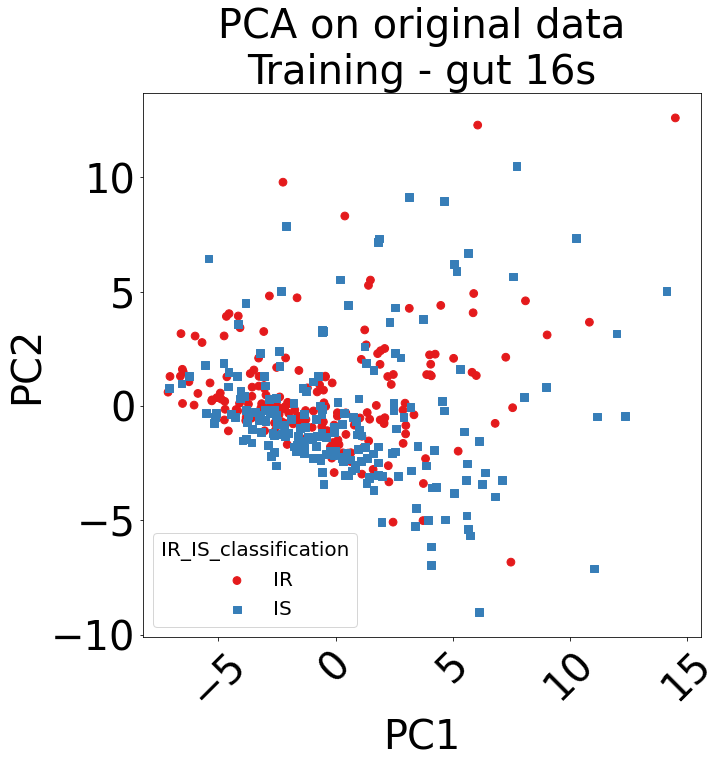

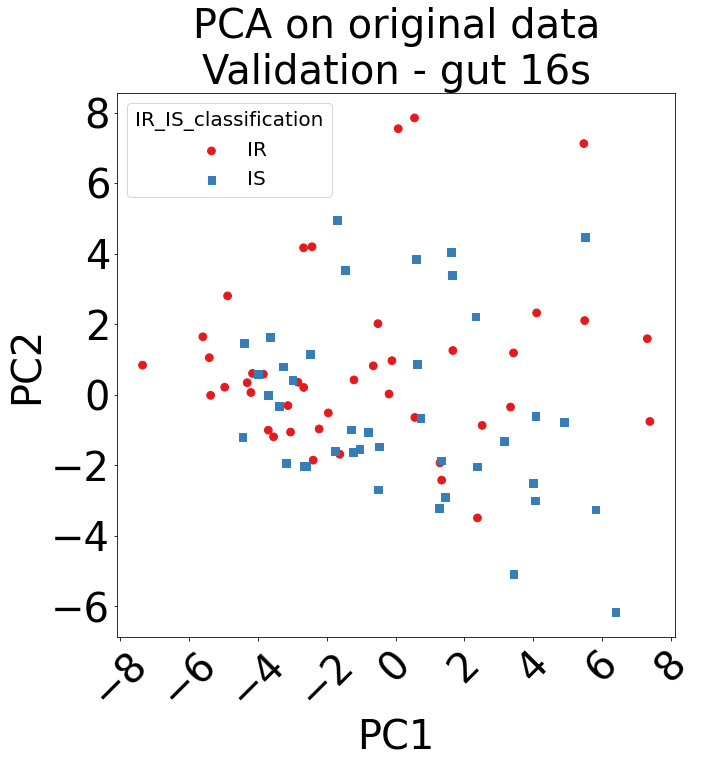

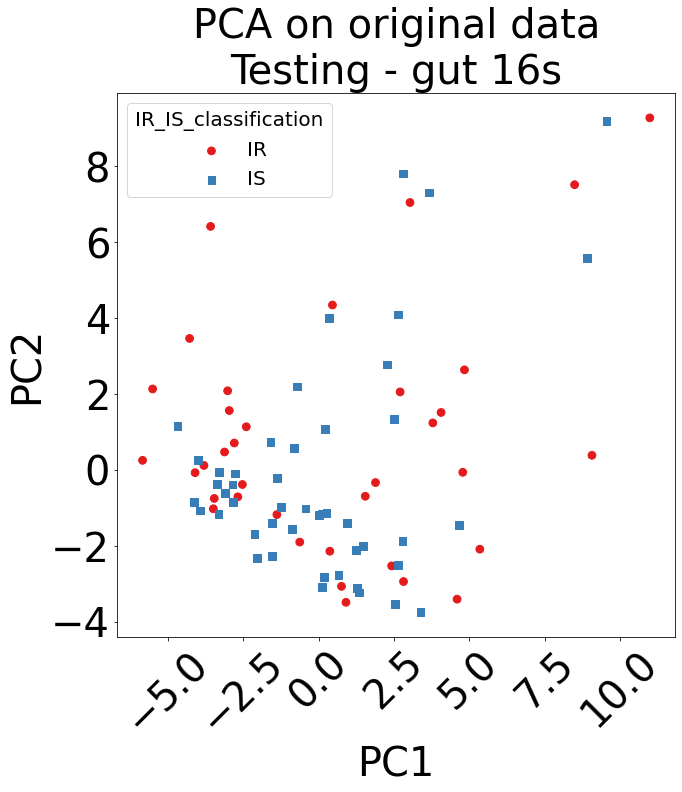

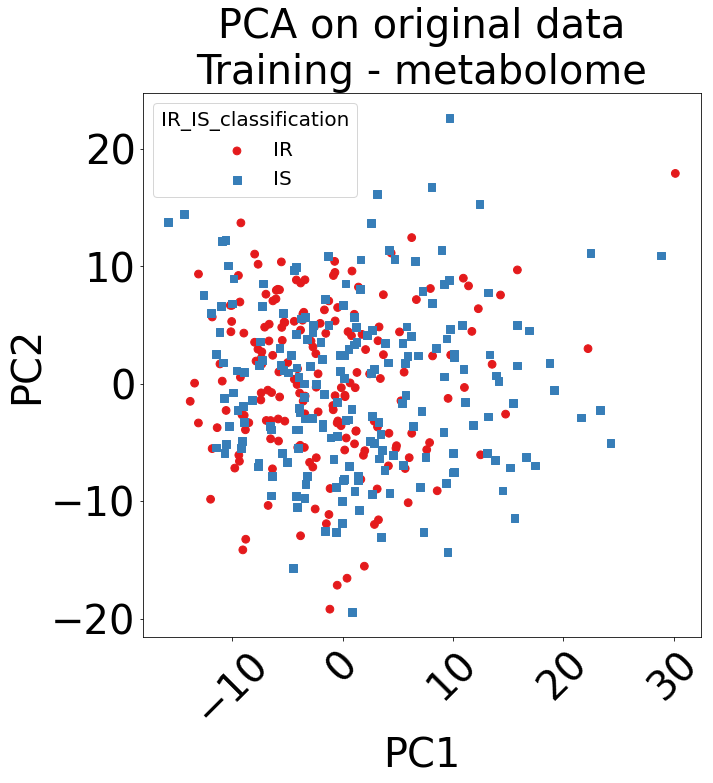

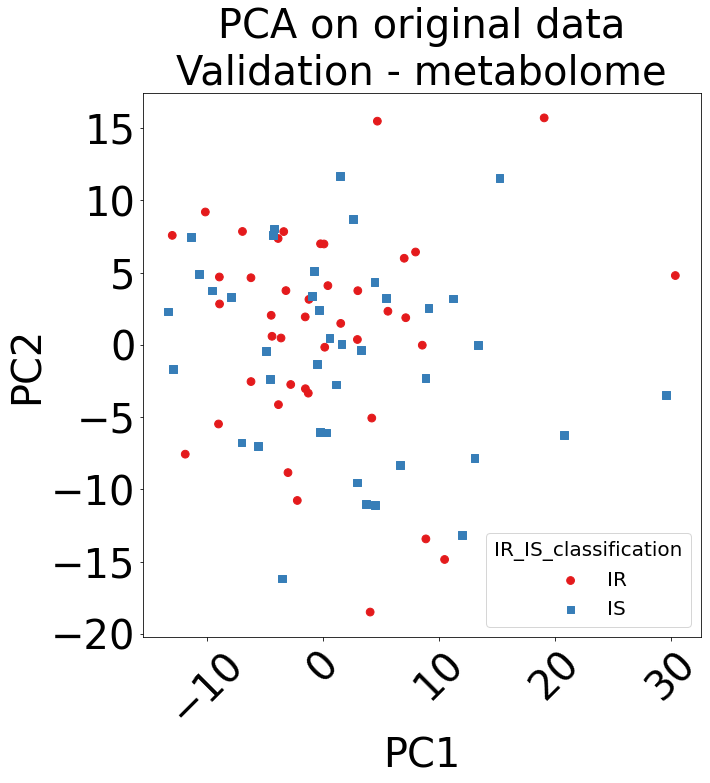

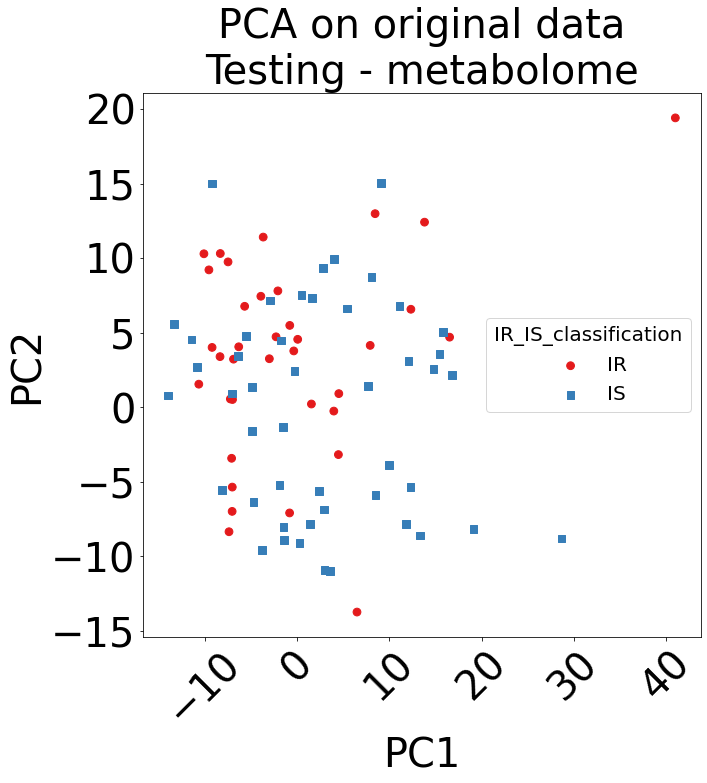

In [6]:
pca_g_iris, pca_g_trans_iris, pca_m_iris, pca_m_trans_iris =\
    pca_scatter_plot_original_data('IR_IS_classification')

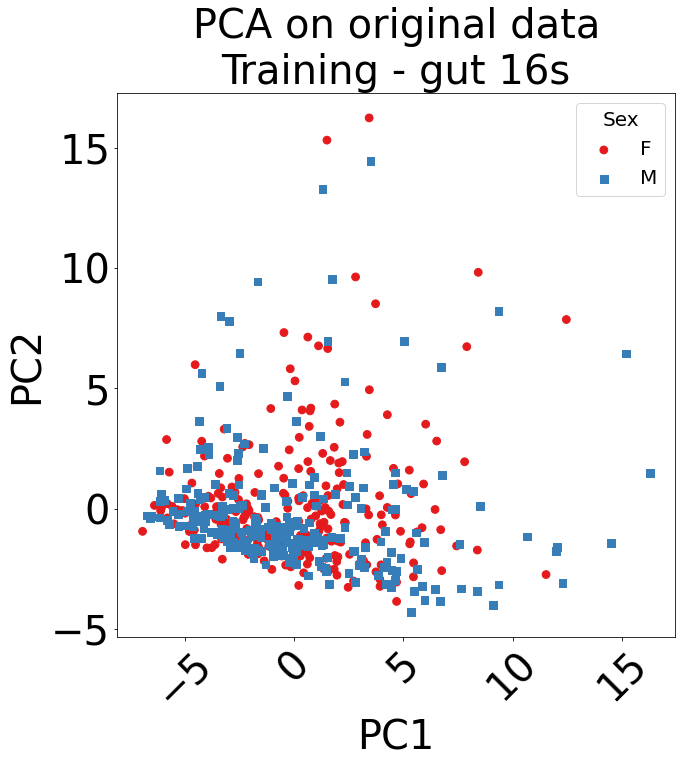

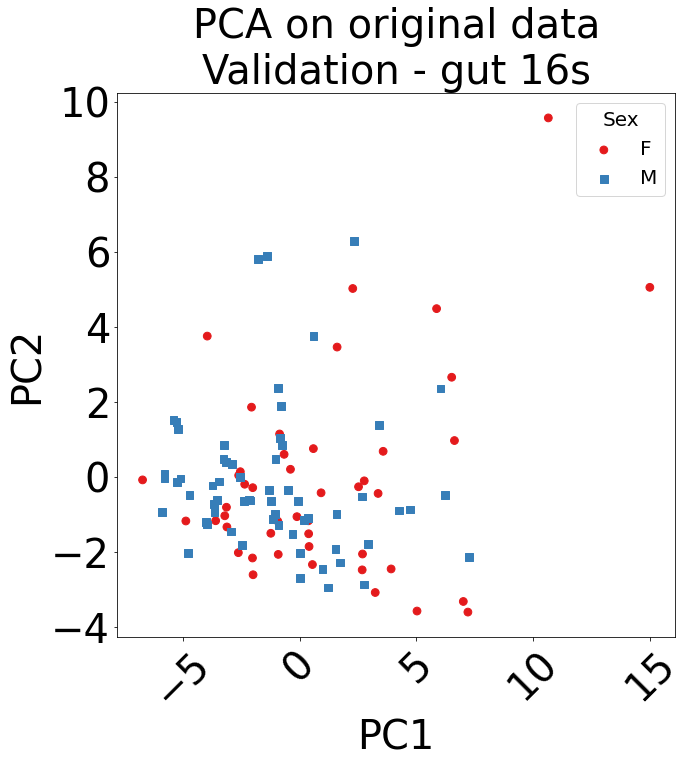

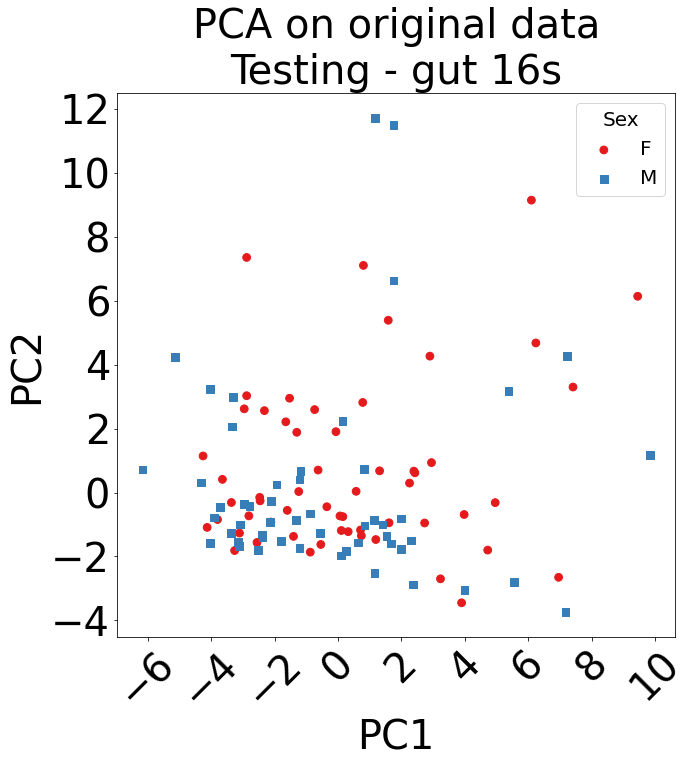

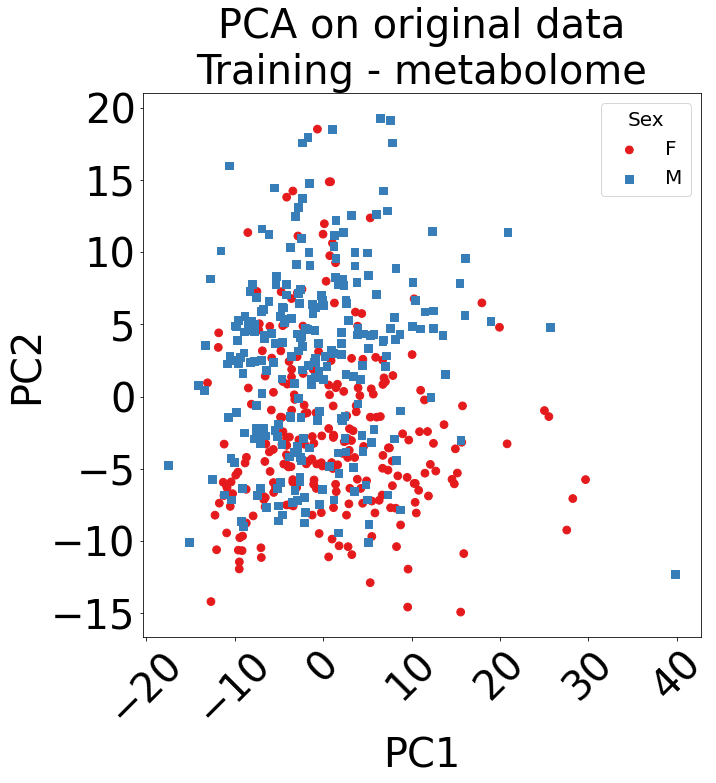

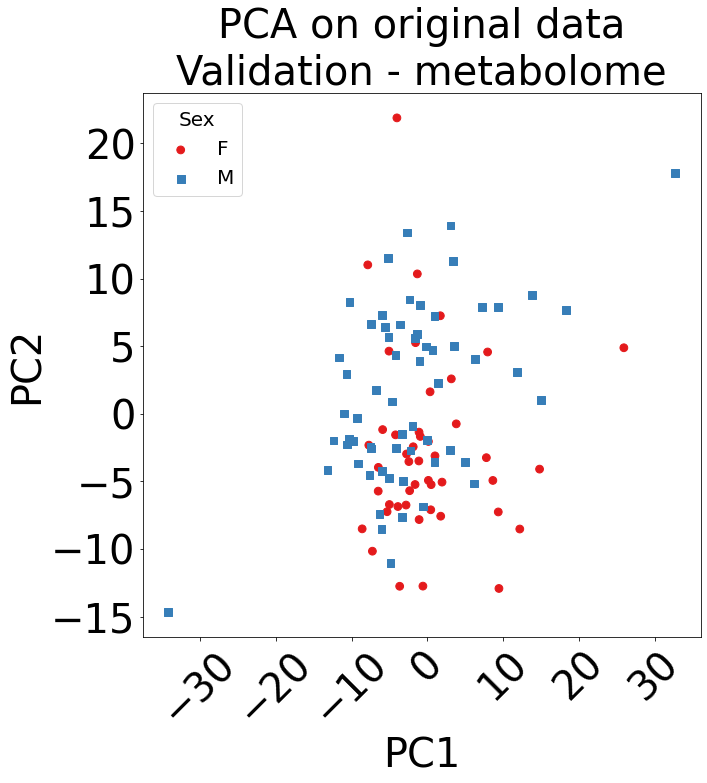

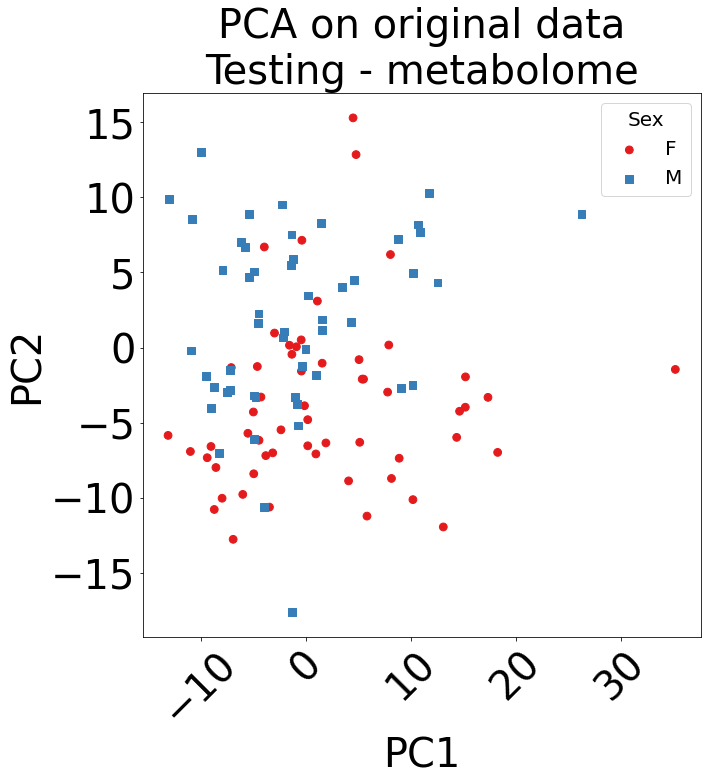

In [7]:
pca_g_sex, pca_g_trans_sex, pca_m_sex, pca_m_trans_sex =\
    pca_scatter_plot_original_data('Sex')

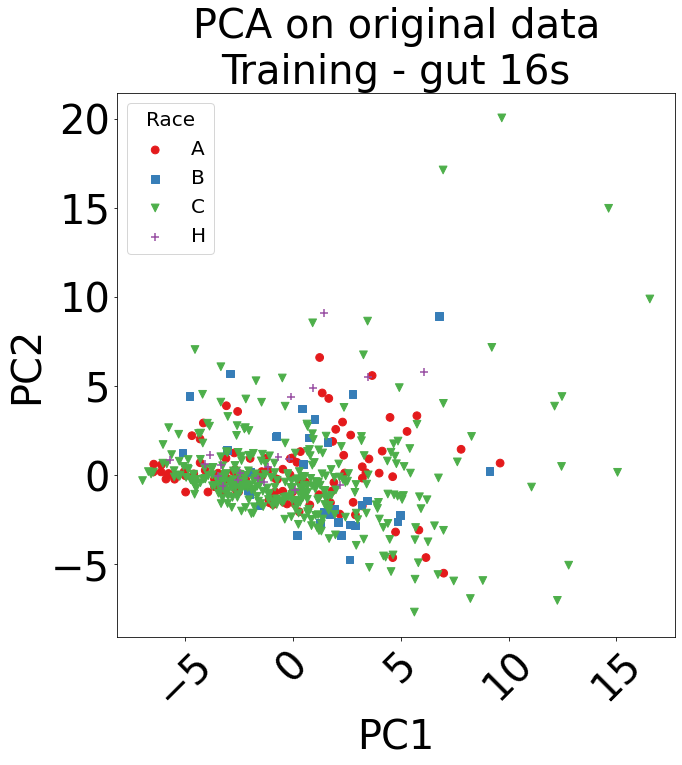

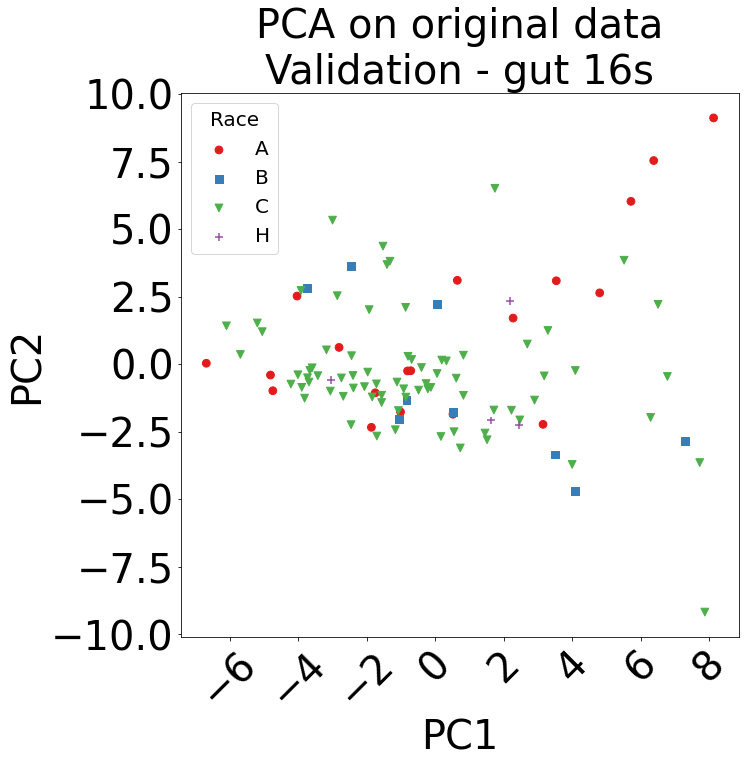

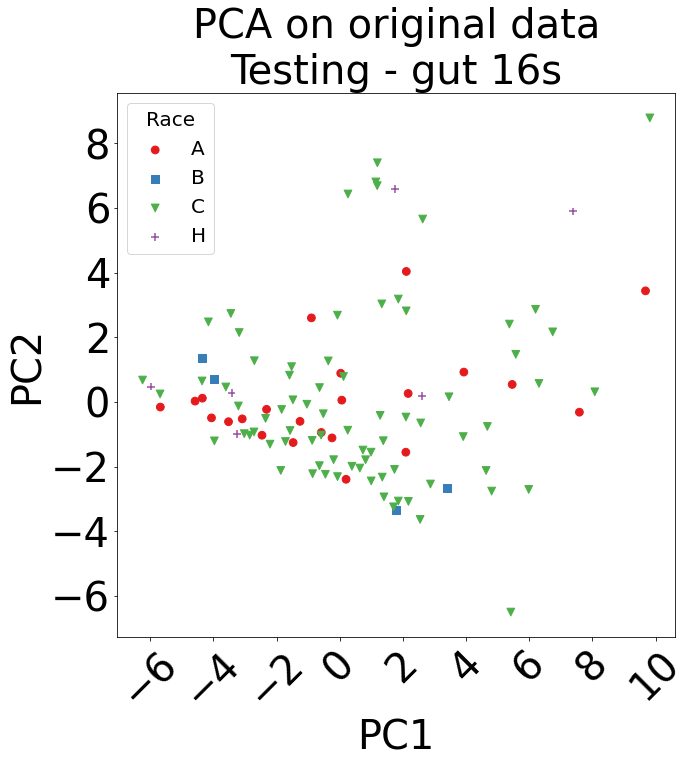

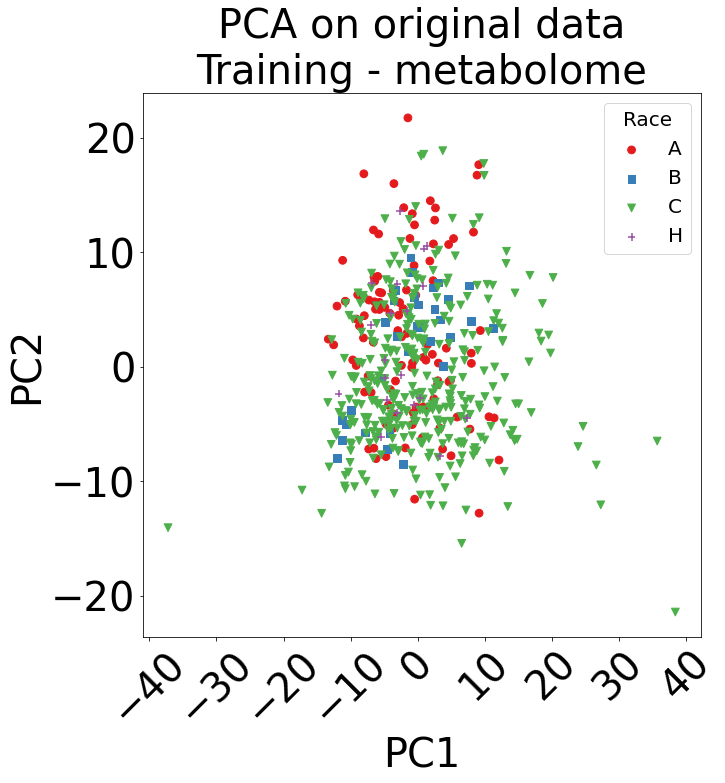

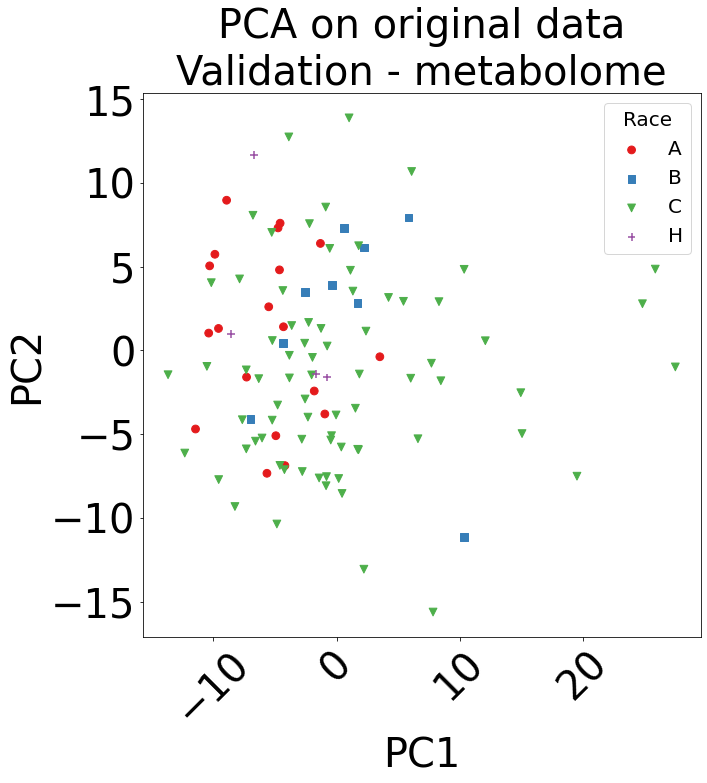

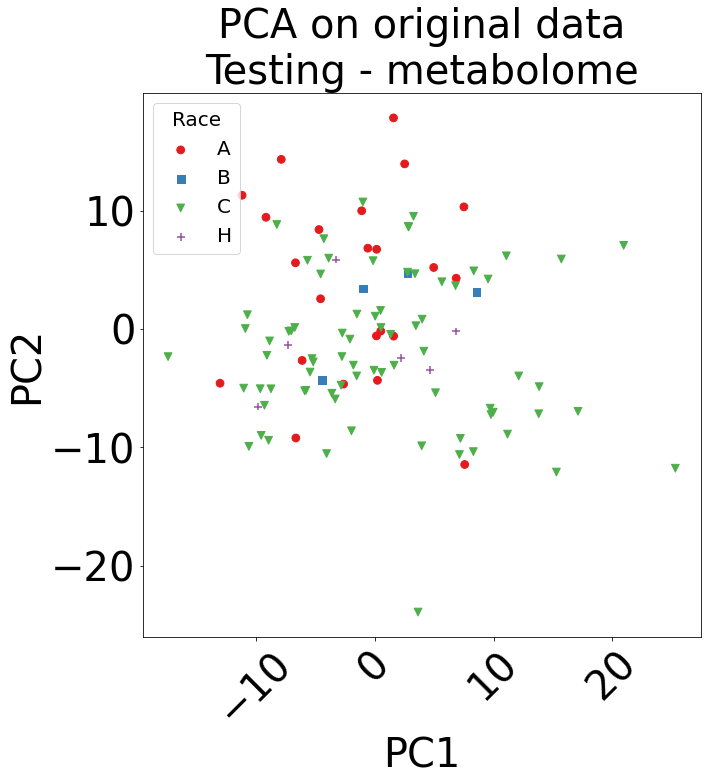

In [8]:
pca_g_race, pca_g_trans_race, pca_m_race, pca_m_trans_race =\
    pca_scatter_plot_original_data('Race')